In [1]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime

In [2]:
# data import 
df = pd.read_excel('Data/Time Series Data.xlsx', index_col = 'Day')
df.head()

# identifying the VIX
vix = df['Series 28'].iloc[0:2600]

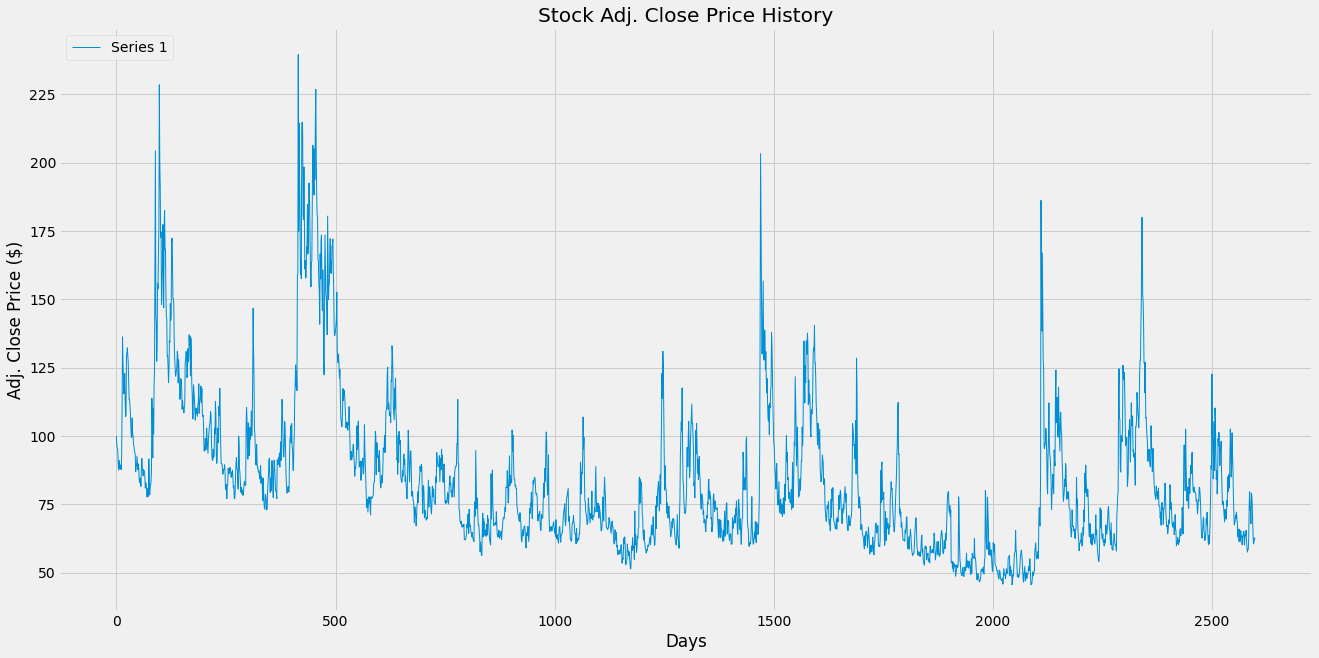

In [3]:
#Visualise the data
plt.figure(figsize=(20, 10))
plt.plot(vix, linewidth = 1)
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(df, loc='upper left')
plt.show()

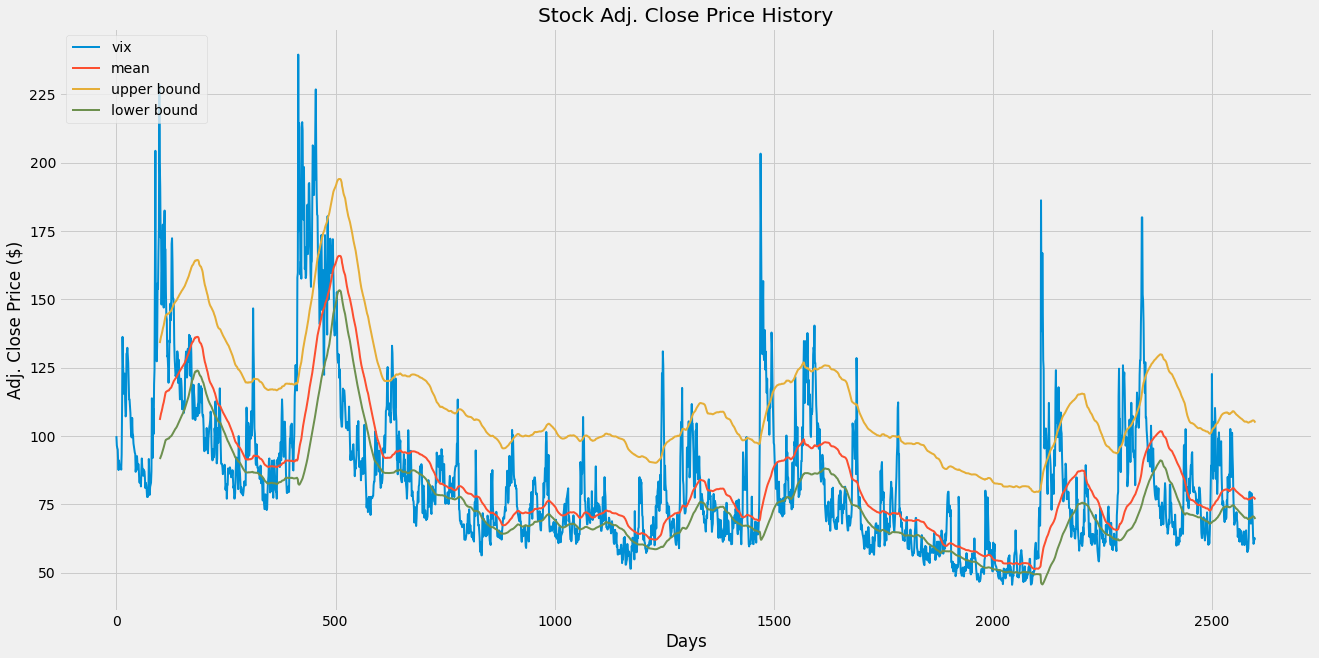

In [18]:
#Visualise the moving average and upper and lower bounds
window=100

# inputs
window_mean = 200
window_std = 100
upper_bound = 1    # number of stdv from mean
lower_bound = 0.5     # number of stdv below mean

# plotting
plt.figure(figsize=(20, 10))
plt.plot(vix, linewidth=2, label='vix')
plt.plot(vix.rolling(window=window).mean(), linewidth=2, label='mean')
plt.plot(vix.rolling(window=window).mean() + upper_bound*vix.std()\
         , linewidth=2, label='upper bound')
plt.plot(vix.rolling(window=window).mean() - lower_bound*vix.rolling(window=window_std).std()\
         , linewidth=2, label='lower bound')

plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(loc='upper left')
plt.show()

In [19]:
# vix strategy

def vixen(data, window_mean, window_std, upper_bound, lower_bound): 
    # generating simple moving average
    
    # data - is the series to generate signals for
    # window - is the window used to generate the average
    # lag - is how far % past the average before a signal is generated
    
    SMA = data.rolling(window = window).mean()
    upper_bounds = SMA + upper_bound*vix.std()
    lower_bounds = SMA - lower_bound*vix.rolling(window=window_std).std()
    
    # generating signals
    sigPriceBuy = []
    sigPriceSell = []
      
    #flag = 1: long position, flag = 0: short position, flag = -1: no position
    flag = -1

    for i in range(len(data)):
        # closing trade at end of session
        if i == len(data)-1:
            if flag == 1:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data.iloc[i])
                flag = 0
            else: 
                sigPriceBuy.append(data.iloc[i])
                sigPriceSell.append(np.nan)
                flag = 0
        # Touch of lower bound = close sell and build long position
        elif data.iloc[i] < lower_bounds.iloc[i]:
            if flag != 1:
                sigPriceBuy.append(data.iloc[i])
                sigPriceSell.append(np.nan)
                flag = 1
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif data.iloc[i] > upper_bounds.iloc[i]:
            if flag != 0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data.iloc[i])
                flag = 0
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else: 
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)

    return (sigPriceBuy, sigPriceSell)

buy_sell_data = vixen(vix, window_mean, window_std, upper_bound, lower_bound)
    

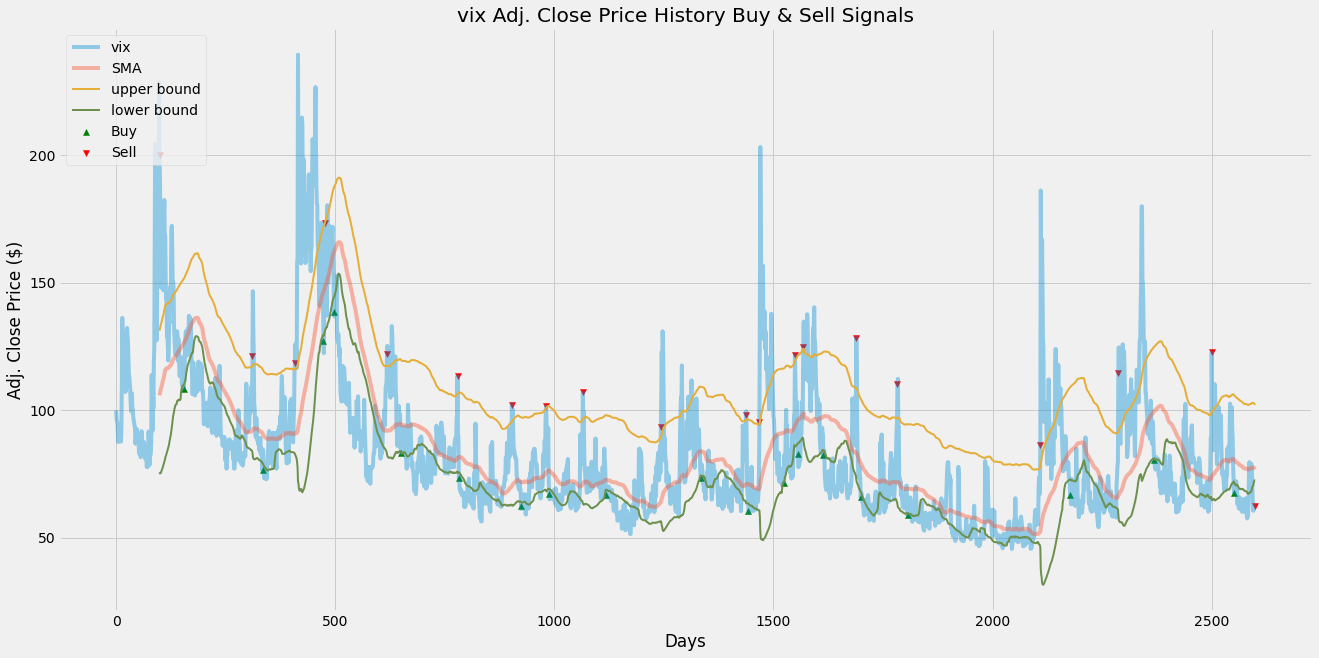

In [20]:
# testing basic strategy
# To test, change window and the series used

# =========================================
# variables
window_mean = 50
window_std = 50
upper_bound = 0.9   # number of stdv from mean
lower_bound = 0.8     # number of stdv below mean
# =========================================

#Store the buy and sell data into a variable
buy_sell_data = vixen(vix, window_mean, window_std, upper_bound, lower_bound)

# visualise test
plt.figure(figsize=(20, 10))
# adding price data
plt.plot(vix, label='vix', alpha=0.4)
plt.plot(vix.rolling(window=window).mean(), label='SMA', alpha=0.4)
plt.plot(vix.rolling(window=window).mean() + upper_bound*vix.std()\
         , linewidth=2, label='upper bound')
plt.plot(vix.rolling(window=window).mean() - lower_bound*vix.rolling(window=window_std).std()\
         , linewidth=2, label='lower bound')

# adding indicators
plt.scatter(vix.index, buy_sell_data[0], label='Buy', marker='^', color='green')
plt.scatter(vix.index, buy_sell_data[1], label='Sell', marker='v', color='red')
plt.title('vix Adj. Close Price History Buy & Sell Signals')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(loc='upper left')
plt.show()

In [17]:
#Calculating returns

def Backtest(data, buy_sell):
    
    profit = np.nansum(buy_sell[1]) - np.nansum(buy_sell[0])
    data_profit = data.iloc[-1] - data.iloc[0]
    
    return profit, data_profit

Backtest(vix, buy_sell_data)

(804.3912175648709, -37.57485029940128)